# Process data from formation cycles

In [1]:
import os

if os.path.basename(os.getcwd()) != 'project-formation':
    os.chdir('..')

import numpy as np
import pandas as pd
import glob
from datetime import datetime
import seaborn as sns
from matplotlib import pyplot as plt
import re

assert os.path.basename(os.getcwd()) == 'project-formation'

## Configure plot settings

In [2]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Times New Roman'],
                  'size': 26
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (10, 8)
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=True)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')


DPI = 150
VOLTAGE_LIMITS = (2.95, 4.25)
CAPACITY_LIMITS = (0, 3)

ORANGE = (1, 0.5, 0)
BLUE = (0, 0.5, 1)
BLACK = (0.0, 0.0, 0.0)
GREEN = (0, 0.75, 0)
ORANGE = (1, 0.5, 0)

## Configure project file path settings

In [3]:
# Data from the 50 batch of cells on Sept 2018
# PROJECT_FOLDER = '2018-09-50-cells/'
# FILE_NAME_REGEX = 'Stefanopoulou_50_Cell_-_Form.[0-9]*.csv'

# Data from June 2020; formation protocol comparison
PROJECT_FOLDER = '2020-06-microformation-timeseries/'
FILE_NAME_REGEX = 'UM_Internal_0620_-_*Form_-_[0-9]*.[0-9]*.csv'

In [4]:
DATA_PATH = 'data/'
OUTPUT_PATH = 'output/'

In [5]:
# Flag cellids to exclude
CELLID_TO_EXCLUDE_ARRAY = [9]

# Current bump cells
CELLID_INTERESTING_1 = [35, 37]

# High CV hold time cells
CELLID_INTERESTING_2 = [36, 38]

In [6]:
file_path_list = sorted(glob.glob(f'{DATA_PATH}{PROJECT_FOLDER}{FILE_NAME_REGEX}'))
print(f'{len(file_path_list)} files discovered:')
for f in file_path_list:
    print(f)

40 files discovered:
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_1.001.csv
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_10.011.csv
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_11.012.csv
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_12.013.csv
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_13.014.csv
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_14.015.csv
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_15.016.csv
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_16.017.csv
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_17.018.csv
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_18.019.csv
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_19.020.csv
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_2.002.csv
data/2020-06-microformation-timeseries/UM_Internal_0620_-_Form_-_20.0

## Load resources

In [7]:
# Do a few unit conversions
df_raw_data_list = []
for file_path in file_path_list:
    df_raw_data = pd.read_csv(file_path)
    df_raw_data['Timestamp'] = pd.to_datetime(df_raw_data['Timestamp'], unit='ms')
    df_raw_data['Cycle Number'] += 1
    df_raw_data_list.append(df_raw_data)

print(df_raw_data_list[0])

      Datapoint Number  Test Time (s)  Cycle Number  Current (A)  \
0                    1           0.00             1     0.000000   
1                    2        1800.00             1     0.000000   
2                    3        3600.00             1     0.000000   
3                    4        5400.00             1     0.000000   
4                    5        7200.00             1     0.000000   
...                ...            ...           ...          ...   
2172              2173      310667.46             3    -0.280461   
2173              2174      310672.25             3    -0.280003   
2174              2175      310677.21             3    -0.280003   
2175              2176      310679.88             3    -0.280003   
2176              2177      310679.88             3     0.000000   

      Potential (V)  Step Index  Step Time (s)  Charge Capacity (Ah)  \
0          0.004273           1           0.00              0.000000   
1          0.000000           1        

### Extract CellIDs from filenames

In [8]:
cell_id_list = []
for f in file_path_list:
    s = re.findall('\_[0-9]*.\.', f)
    s = int(s[0][1:-1])
    cell_id_list.append(s)
cell_id_list = np.array(cell_id_list)
print(cell_id_list)

[ 1 10 11 12 13 14 15 16 17 18 19  2 20  3  4  5  6  7  8  9 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]


### Load all data into DataFrame

In [9]:
print(df_raw_data_list[0].columns)

Index(['Datapoint Number', 'Test Time (s)', 'Cycle Number', 'Current (A)',
       'Potential (V)', 'Step Index', 'Step Time (s)', 'Charge Capacity (Ah)',
       'Discharge Capacity (Ah)', 'Charge Energy (Wh)',
       'Discharge Energy (Wh)', 'Timestamp', 'dV/dt (V/s)', 'dQ/dV (Ah/V)',
       'Current Cycle Net Capacity (Ah)', 'Current Cycle Net Energy (Wh)',
       'Test Net Capacity (Ah)', 'Test Net Energy (Wh)',
       'Test Cumulative Capacity (Ah)', 'Test Cumulative Energy (Wh)',
       'Power (W)', '[Maccor] Datapoint ID', '[Maccor] Cycle',
       '[Maccor] Step Index', '[Maccor] Test Time (s)',
       '[Maccor] Step Time (s)', '[Maccor] Capacity (Ah)',
       '[Maccor] Energy (Wh)', '[Maccor] Current (A)',
       '[Maccor] Potential (V)', '[Maccor] State', '[Maccor] Ending Status',
       '[Maccor] Datapoint Time', '[Maccor] AC Impedance (Ω)',
       '[Maccor] Internal Resistance (Ω)', '[Maccor] VAR 1', '[Maccor] VAR 10',
       '[Maccor] VAR 11', '[Maccor] VAR 12', '[Maccor] VAR

### Build the cycle-by-cycle summary statistics table

In [10]:
df_by_cycle_list = list()
for df in df_raw_data_list:

    # Do cycle by cycle aggregation
    df_by_cycle = df \
                   .groupby('Cycle Number', as_index=False) \
                   .agg({
                       'Charge Capacity (Ah)': max, 
                       'Discharge Capacity (Ah)': max,
                       'Timestamp': min
                       })
    
    # Define coulombic efficiency cycle by cycle
    df_by_cycle['Coulombic Efficiency (%)'] = df_by_cycle['Discharge Capacity (Ah)']/df_by_cycle['Charge Capacity (Ah)']*100
    
    # Drop cycles with 0 charge capacity
    df_by_cycle = df_by_cycle[df_by_cycle['Charge Capacity (Ah)'] != 0]
    df_by_cycle_list.append(df_by_cycle)

print(df_by_cycle_list[5])

   Cycle Number  Charge Capacity (Ah)  Discharge Capacity (Ah)  \
0             1              2.721176                 2.305634   
1             2              2.360529                 2.360697   
2             3              2.378012                 2.362916   

            Timestamp  Coulombic Efficiency (%)  
0 2020-06-16 15:22:43                 84.729319  
1 2020-06-18 11:28:01                100.007135  
2 2020-06-19 05:48:16                 99.365176  


### Build the cycle-by-cycle index of features (e.g. dQ/dV)
For each cell, this is given as a list of dicts, one dict for each cycle. There's probably a better way to do this...

In [11]:
features_list = list()

for df in df_raw_data_list:

    features_by_cycle_list = list()

    for n in df['Cycle Number'].unique().tolist():

        iloc = df['Cycle Number'] == n

        if max(df['Charge Capacity (Ah)'][iloc]) == 0:
            continue

        features_dict = dict()
        features_dict['n'] = n
        features_dict['Q'] = df['Charge Capacity (Ah)'][iloc]
        features_dict['V'] = df['Potential (V)'][iloc]
        features_dict['dQdV'] = df['dQ/dV (Ah/V)'][iloc]
        features_dict['Qd'] = df['Discharge Capacity (Ah)'][iloc]

        features_by_cycle_list.append(features_dict)

    features_list.append(features_by_cycle_list)

### Summarize aggregate metrics across all cells

In [12]:
fce_list = list()
capacity_list = list()
for df in df_by_cycle_list:

    # The coulombic efficiency is taken from the first cycle
    fce_list.append(df['Coulombic Efficiency (%)'][0])

    # The discharge capacity to report is the taken from the last cycle
    capacity_list.append(df['Discharge Capacity (Ah)'].iloc[-1])
    
fce_list = np.array(fce_list)
capacity_list = np.array(capacity_list)

df_summary = pd.DataFrame(data={'Cell ID': cell_id_list, 
                                'Capacity (Ah)': capacity_list, 
                                'FCE (%)': fce_list})
df_summary.set_index('Cell ID')

,Capacity (Ah),FCE (%)
Cell ID,,
1,2.367225,83.937584
10,2.384860,86.932127
11,2.389859,86.617452
12,2.383074,86.110726
13,2.373780,85.423539
14,2.362916,84.729319
15,2.372936,84.417515
16,2.355407,85.835587
17,2.366808,85.301438


## Plot the main results

### Time-series data by cell

In [13]:
for cell_index, df in enumerate(df_raw_data_list):

    fig = plt.figure(figsize=(8, 5))
    ax1 = fig.add_subplot(211)
    ax1.plot(df['Test Time (s)']/3600, df['Potential (V)'], '.-', 
            linewidth=1, 
            mec='r', 
            c='k',
            markersize=3)

    ax1.set_ylabel('Voltage (V)')
    ax1.set_ylim(VOLTAGE_LIMITS)
    ax1.set_title(f'Cell {cell_id_list[cell_index]} Raw Data')

    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.plot(df['Test Time (s)']/3600, df['Current (A)'], '.-', 
            linewidth=1, 
            mec='r', 
            c='k',
            markersize=3)

    ax2.set_xlabel('Test Time (hrs)')
    ax2.set_ylabel('Current (A)')

    plt.tight_layout()

    plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}raw_data_cell_{cell_id_list[cell_index]}.png", dpi=DPI)

    plt.close()

### Features by cycle number

In [14]:
for cell, features_by_cycle_list in enumerate(features_list):

    print(f'Exporting plots for cell {cell}')

    fig = plt.figure(figsize=(10,10.5))

    ax1 = fig.add_subplot(311)
    ax1.set_title(f'Cell {cell_id_list[cell_index]} : Voltage Curve')
    ax1.set_xlabel('Charge Capacity (Ah)')
    ax1.set_ylabel('Voltage (V)')
    ax1.set_xlim(CAPACITY_LIMITS)
    ax1.set_ylim(VOLTAGE_LIMITS)
    for features in features_by_cycle_list:
        ax1.plot(features['Q'], features['V'], label=f"Cycle {features['n']}")
    ax1.legend()

    # dV/dQ
    ax2 = fig.add_subplot(312)
    ax2.set_title(f'Cell {cell_id_list[cell_index]} : Differential Voltage')
    ax2.set_xlabel('Capacity (Ah)')
    ax2.set_ylabel('dV/dQ (V/Ah)')
    ax2.set_xlim(CAPACITY_LIMITS)
    ax2.set_ylim((0, 0.6))
    for features in features_by_cycle_list:
        ax2.plot(features['Q'], 1/features['dQdV'], label=f"Cycle {features['n']}")
    ax2.legend()

    # dQ/dV
    ax3 = fig.add_subplot(313)
    ax3.set_title(f'Cell {cell_id_list[cell_index]} : Differential Capacity')
    ax3.set_xlabel('Voltage (V)')
    ax3.set_ylabel('dQ/dV (Ah/V)')
    ax3.set_ylim((0, 13))
    ax3.set_xlim((3.0, 4.2))
    for features in features_by_cycle_list:
        ax3.plot(features['V'], features['dQdV'], label=f"Cycle {features['n']}")
    ax3.legend()

    plt.tight_layout()
    plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)
    plt.close()

Exporting plots for cell 0
Exporting plots for cell 1
Exporting plots for cell 2
Exporting plots for cell 3
Exporting plots for cell 4
Exporting plots for cell 5
Exporting plots for cell 6
Exporting plots for cell 7
Exporting plots for cell 8
Exporting plots for cell 9
Exporting plots for cell 10
Exporting plots for cell 11
Exporting plots for cell 12
Exporting plots for cell 13
Exporting plots for cell 14
Exporting plots for cell 15
Exporting plots for cell 16
Exporting plots for cell 17
Exporting plots for cell 18
Exporting plots for cell 19
Exporting plots for cell 20


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 21


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 22


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 23


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 24


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 25


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 26


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 27


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 28


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 29


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 30


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 31


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 32


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 33


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 34


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 35


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 36


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 37


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 38


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


Exporting plots for cell 39


<ipython-input-14-76b828700ed6>:40: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}voltage_curves_cell_{cell_id_list[cell_index]}.png", dpi=DPI)


### Capacity by cycle number

In [15]:
for cell_index, df_by_cycle in enumerate(df_by_cycle_list):
    ax1 = plt.plot()
    ax1 = plt.gca()
    ax1.set_title(f"Cell {cell_id_list[cell_index]}, FCE = {df_by_cycle['Coulombic Efficiency (%)'][0]:.1f}%")
    ax1.set_xlabel('Cycle Number')
    ax1.set_ylabel('Capacity (Ah)')
    ax1.set_ylim(CAPACITY_LIMITS)

    ax1.plot(df_by_cycle['Cycle Number'], df_by_cycle['Charge Capacity (Ah)'], 'o-', label='Charge')
    ax1.plot(df_by_cycle['Cycle Number'], df_by_cycle['Discharge Capacity (Ah)'], 'o-', label='Discharge')

    ax1.legend()
    plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}capacity_by_cycle_cell_{cell_id_list[cell_index]}.png", dpi=DPI)
    plt.close()

### Summary statistics for all cells

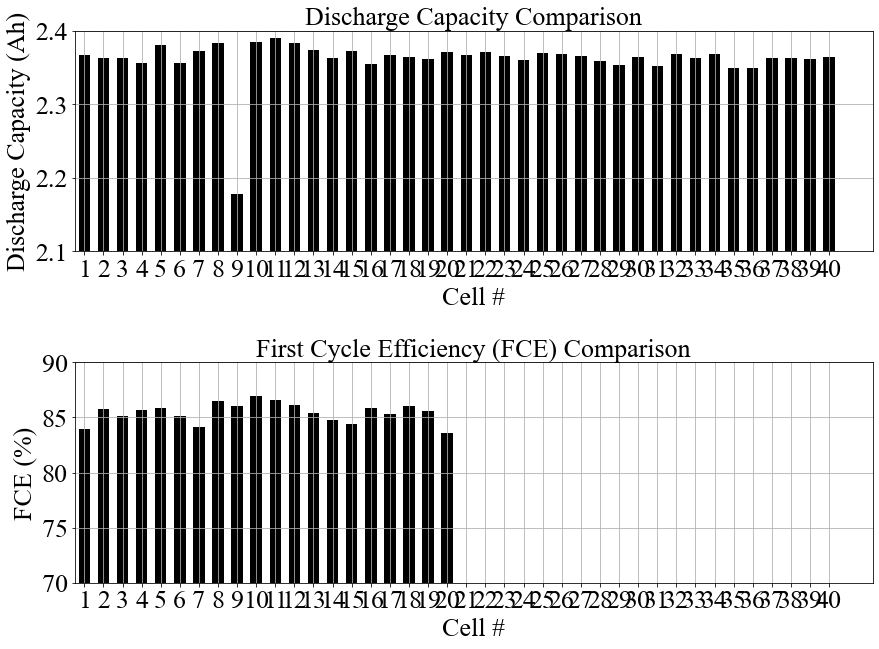

In [16]:
width = 0.6

fig = plt.figure(figsize=(12.8, 9.6))

ax1 = fig.add_subplot(211)
ax1.set_title('Discharge Capacity Comparison')
ax1.set_ylabel('Discharge Capacity (Ah)')
ax1.set_xlabel('Cell #')
ax1.set_ylim((2.1, 2.4))
ax1.bar(cell_id_list, capacity_list, color='k', width=width)
ax1.set_xticks(np.arange(1, max(cell_id_list)+1))
ax1.set_xlim(left=0.5)

ax2 = fig.add_subplot(212)
ax2.set_title('First Cycle Efficiency (FCE) Comparison')
ax2.set_ylabel('FCE (%)')
ax2.set_ylim((70, 90))
ax2.set_xlabel('Cell #')
ax2.bar(cell_id_list, fce_list, color='k', width=width)
ax2.set_xticks(np.arange(1, max(cell_id_list)+1))
ax2.set_xlim(left=0.5)

plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}all_cells_discharge_capacity.png", dpi=DPI)


### Correlation plot

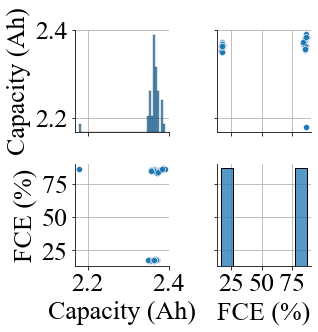

In [17]:
# Remove outliers first from manual data inspection
# df_summary = df_summary[df_summary['FCE (%)'] > 80]

# sns.set(style="ticks", color_codes=True, font='Helvetica')
g = sns.pairplot(df_summary, vars=['Capacity (Ah)', 'FCE (%)'])
g.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}all_cells_correlation_plot.png", dpi=DPI)

## Study micro-formation cycle specific information
The data below is used to parse data coming specifically from the micro-formation cycling


### Initial chage voltage step (1C to 3.9V --> C/5 to 4.2V)

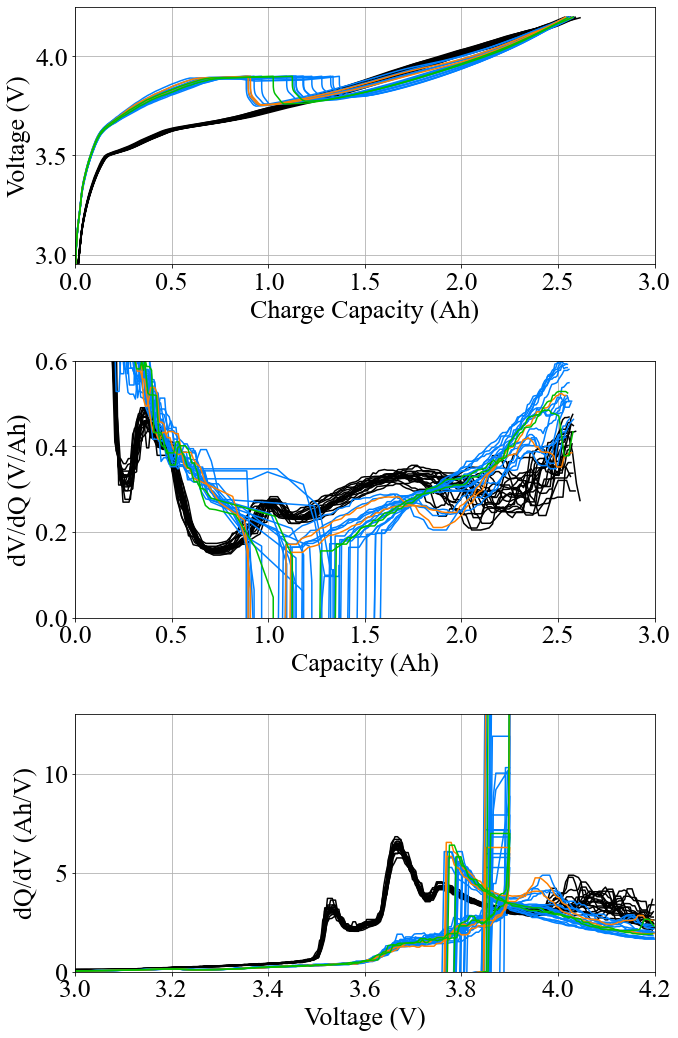

In [42]:
CYCLE_INDEX_TO_PLOT = 0

fig = plt.figure(figsize=(10,15))

# Voltage vs Capacity
ax1 = fig.add_subplot(311)
# ax1.set_title(f'Voltage Curve')
ax1.set_xlabel('Charge Capacity (Ah)')
ax1.set_ylabel('Voltage (V)')
ax1.set_xlim(CAPACITY_LIMITS)
ax1.set_ylim(VOLTAGE_LIMITS)

# dV/dQ
ax2 = fig.add_subplot(312)
# ax2.set_title(f'Differential Voltage')
ax2.set_xlabel('Capacity (Ah)')
ax2.set_ylabel('dV/dQ (V/Ah)')
ax2.set_xlim(CAPACITY_LIMITS)
ax2.set_ylim((0, 0.6))

# dQ/dV
ax3 = fig.add_subplot(313)
# ax3.set_title(f'Differential Capacity')
ax3.set_xlabel('Voltage (V)')
ax3.set_ylabel('dQ/dV (Ah/V)')
ax3.set_ylim((0, 13))
ax3.set_xlim((3.0, 4.2))
    
idx_of_interest_1 = []
idx_of_interest_2 = []

for idx, features_by_cycle_list in enumerate(features_list):
    
    is_micro_formation = len(re.findall(r'_MicroForm_', file_path_list[idx])) > 0

    cellid = cell_id_list[idx]

    color = BLUE if is_micro_formation else BLACK

    # Manually inspect the data and pick out cells to highlight
    # These cellids are picked based on which cells have had a current bump
    if cellid in CELLID_INTERESTING_1:
        idx_of_interest_1.append(idx)
        continue
    if cellid in CELLID_INTERESTING_2:
        idx_of_interest_2.append(idx)
        continue
    elif cellid in CELLID_TO_EXCLUDE_ARRAY:
        continue
    
    label = "_nolegend_"

    features = features_by_cycle_list[CYCLE_INDEX_TO_PLOT]
    
    idx_end = int(np.where(features['Q'] == np.min(features['Q'].iloc[np.where(features['V'] > 4.199)[0]]))[0])

    ax1.plot(features['Q'].iloc[0:idx_end], features['V'].iloc[0:idx_end], label=label, color=color)
    ax2.plot(features['Q'].iloc[0:idx_end], 1/features['dQdV'][0:idx_end].rolling(5).median(), label=label, color=color)
    ax3.plot(features['V'].iloc[0:idx_end], features['dQdV'].iloc[0:idx_end].rolling(5).median(), label=label, color=color)

for idx in idx_of_interest_1:
    
    features_by_cycle_list = features_list[idx]
    cellid = cell_id_list[idx]
    
    features = features_by_cycle_list[CYCLE_INDEX_TO_PLOT]
    
    idx_end = int(np.where(features['Q'] == np.min(features['Q'].iloc[np.where(features['V'] > 4.199)[0]]))[0])

    color = ORANGE
    label= f'Cell {cellid}'
    
    ax1.plot(features['Q'].iloc[0:idx_end], features['V'].iloc[0:idx_end], label=label, color=color)
    ax2.plot(features['Q'].iloc[0:idx_end], 1/features['dQdV'][0:idx_end].rolling(5).median(), label=label, color=color)
    ax3.plot(features['V'].iloc[0:idx_end], features['dQdV'].iloc[0:idx_end].rolling(5).median(), label=label, color=color)


for idx in idx_of_interest_2:
    
    features_by_cycle_list = features_list[idx]
    cellid = cell_id_list[idx]
    
    features = features_by_cycle_list[CYCLE_INDEX_TO_PLOT]
    
    idx_end = int(np.where(features['Q'] == np.min(features['Q'].iloc[np.where(features['V'] > 4.199)[0]]))[0])

    color = GREEN
    label= f'Cell {cellid}'
    
    ax1.plot(features['Q'].iloc[0:idx_end], features['V'].iloc[0:idx_end], label=label, color=color)
    ax2.plot(features['Q'].iloc[0:idx_end], 1/features['dQdV'][0:idx_end].rolling(5).median(), label=label, color=color)
    ax3.plot(features['V'].iloc[0:idx_end], features['dQdV'].iloc[0:idx_end].rolling(5).median(), label=label, color=color)
    

plt.tight_layout()

### Subsequent CV hold step
Plot the current decay during the CV hold

In [19]:
df_raw_data_list[0][df_raw_data_list[0]['Step Index'] == 5]

,Datapoint Number,Test Time (s),Cycle Number,Current (A),Potential (V),Step Index,Step Time (s),Charge Capacity (Ah),Discharge Capacity (Ah),Charge Energy (Wh),...,[Maccor] VAR 14,[Maccor] VAR 15,[Maccor] VAR 2,[Maccor] VAR 3,[Maccor] VAR 4,[Maccor] VAR 5,[Maccor] VAR 6,[Maccor] VAR 7,[Maccor] VAR 8,[Maccor] VAR 9
540,541,126865.38,1,0.0,4.199512,5,0.01,2.755302,0.0,10.547212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541,542,126895.38,1,0.0,4.198520,5,30.01,2.755302,0.0,10.547212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
542,543,126925.38,1,0.0,4.198062,5,60.01,2.755302,0.0,10.547212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
543,544,126955.38,1,0.0,4.197528,5,90.01,2.755302,0.0,10.547212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
544,545,126985.38,1,0.0,4.197147,5,120.01,2.755302,0.0,10.547212,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,1117,194095.32,2,0.0,4.190585,5,1680.01,2.376408,0.0,8.985356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1117,1118,194125.32,2,0.0,4.190661,5,1710.01,2.376408,0.0,8.985356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1118,1119,194155.32,2,0.0,4.190585,5,1740.01,2.376408,0.0,8.985356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1119,1120,194185.32,2,0.0,4.190356,5,1770.01,2.376408,0.0,8.985356,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Voltage decay during the 6-hour rest step

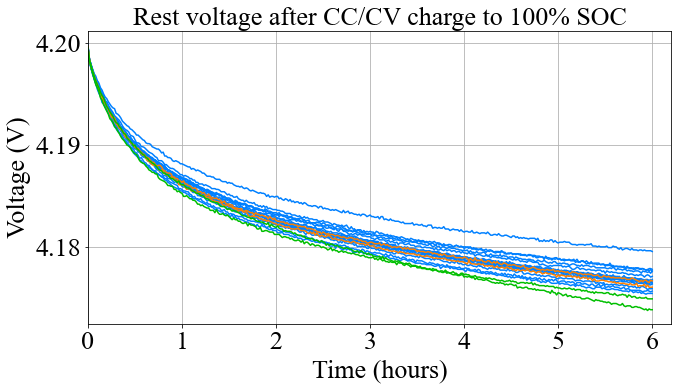

In [35]:
fig = plt.figure(figsize=(10,6))

# Voltage vs Capacity
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Voltage (V)')
    
idx_of_interest_1 = []
idx_of_interest_2 = []

for idx, df_raw_data in enumerate(df_raw_data_list):
    
    cellid = cell_id_list[idx]

    # print(f'working on cell {cellid}')
    # Only plot micro-formation cycles
    is_micro_formation = len(re.findall(r'_MicroForm_', file_path_list[idx])) > 0
    
    color = BLUE if is_micro_formation else BLACK

    # Define cycle and step indices of interest. This is schedule version-specific.
    if is_micro_formation:
        STEP_INDEX_TO_PLOT = 13
        CYCLE_INDEX_TO_PLOT = 7
    else:
        STEP_INDEX_TO_PLOT = 12
        CYCLE_INDEX_TO_PLOT = 3

    # Manually inspect the data and pick out cells to highlight
    if cellid in CELLID_INTERESTING_1:
        idx_of_interest_1.append(idx)
        continue
    if cellid in CELLID_INTERESTING_2:
        idx_of_interest_2.append(idx)
        continue
    elif cellid in CELLID_TO_EXCLUDE_ARRAY:
        continue
    elif not is_micro_formation:
        continue

    data = df_raw_data[(df_raw_data['Step Index'] == STEP_INDEX_TO_PLOT) & 
                       (df_raw_data['Cycle Number'] == CYCLE_INDEX_TO_PLOT)]

    ax1.plot(data['Step Time (s)']/60/60, 
             data['Potential (V)'], label=label, color=color)

for idx in idx_of_interest_1:
    
    df_raw_data = df_raw_data_list[idx]
    cellid = cell_id_list[idx]
    
    data = df_raw_data[(df_raw_data['Step Index'] == STEP_INDEX_TO_PLOT) & 
                       (df_raw_data['Cycle Number'] == CYCLE_INDEX_TO_PLOT)]

    ax1.plot(data['Step Time (s)']/60/60, 
             data['Potential (V)'], label=f'Cell {cellid}', color=ORANGE)
    

for idx in idx_of_interest_2:
    
    df_raw_data = df_raw_data_list[idx]
    cellid = cell_id_list[idx]
    
    data = df_raw_data[(df_raw_data['Step Index'] == STEP_INDEX_TO_PLOT) & 
                       (df_raw_data['Cycle Number'] == CYCLE_INDEX_TO_PLOT)]

    ax1.plot(data['Step Time (s)']/60/60, 
             data['Potential (V)'], label=f'Cell {cellid}', color=GREEN)
    
plt.title('Rest voltage after CC/CV charge to 100% SOC')
plt.xlim((0,6.2))
# plt.legend()
plt.tight_layout()

## Current decay during first CV hold step
We will only be able to plot the data for the micro-formation tests because the corresponding dataset for the baseline formation is missing (the baseline formation schedule files did not log data points during the CV hold steps).

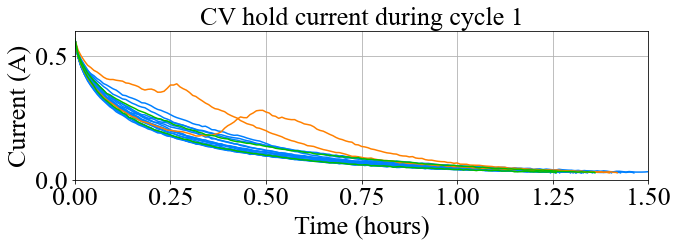

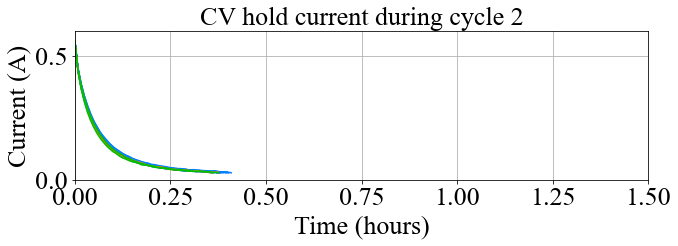

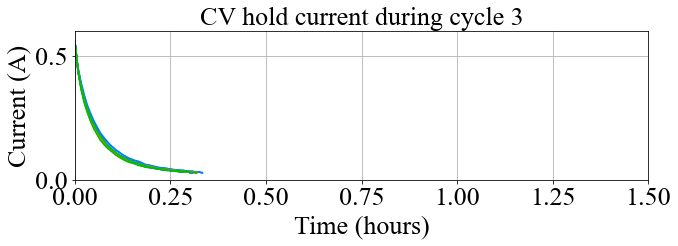

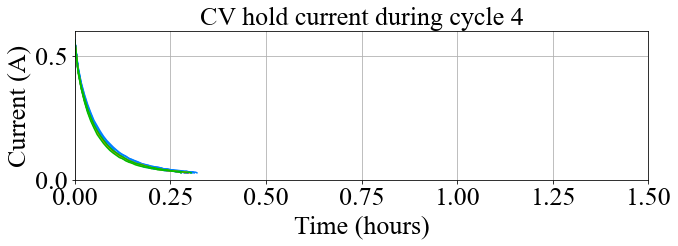

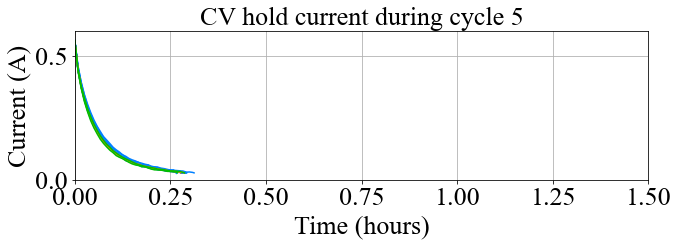

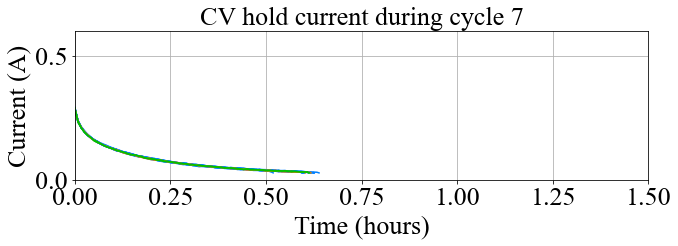

In [43]:
# Define cycle and step indices of interest. This is schedule version specific.
# Note that the Baseline Formation schedule is missing data logging during this CV hold step
step_index_arr = [5, 5, 5, 5, 5, 12]
cycle_index_arr = [1, 2, 3, 4, 5, 7]

for cycle_index, step_index in zip(cycle_index_arr, step_index_arr):
    
    fig = plt.figure(figsize=(10,4))

    # Voltage vs Capacity
    ax1 = fig.add_subplot(111)
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Current (A)')

    idx_of_interest_1 = []
    idx_of_interest_2 = []
    
    for idx, df_raw_data in enumerate(df_raw_data_list):

        # Only plot micro-formation cycles.
        is_micro_formation = len(re.findall(r'_MicroForm_', file_path_list[idx])) > 0
        if not is_micro_formation:
            continue

        cellid = cell_id_list[idx]

        # Manually inspect the data and pick out cells to highlight; skip plotting these until the very end
        if cellid in CELLID_INTERESTING_1:
            idx_of_interest_1.append(idx)
            continue
        elif cellid in CELLID_INTERESTING_2:
            idx_of_interest_2.append(idx)
            continue
        
        color = BLUE
        label = "_nolegend_"

        data = df_raw_data[(df_raw_data['Step Index'] == step_index) & 
                           (df_raw_data['Cycle Number'] == cycle_index)]

        ax1.plot(data['Step Time (s)']/60/60, data['Current (A)'], label=label, color=color)

    # Plot the cells of interest last so that these lines are in front of the other lines
    for idx in idx_of_interest_1:
        
        df_raw_data = df_raw_data_list[idx]
        cellid = cell_id_list[idx]
        data = df_raw_data[(df_raw_data['Step Index'] == step_index) &
                           (df_raw_data['Cycle Number'] == cycle_index)]
        
        ax1.plot(data['Step Time (s)']/60/60, data['Current (A)'], label=f'Cell {cellid}', color=ORANGE)
        
    for idx in idx_of_interest_2:
        
        df_raw_data = df_raw_data_list[idx]
        cellid = cell_id_list[idx]
        data = df_raw_data[(df_raw_data['Step Index'] == step_index) &
                           (df_raw_data['Cycle Number'] == cycle_index)]
        
        ax1.plot(data['Step Time (s)']/60/60, data['Current (A)'], label=f'Cell {cellid}', color=GREEN)
    
        
    plt.title(f'CV hold current during cycle {cycle_index}')
#     plt.title('CV hold current after first charge')
    plt.xlim((0, 1.5))
    plt.ylim((0, 0.6))
#     plt.legend()
    plt.tight_layout()
    plt.show()

### Final C/10 charge step. 
Compare this apples-to-apples with the baseline profile

### Charge curves

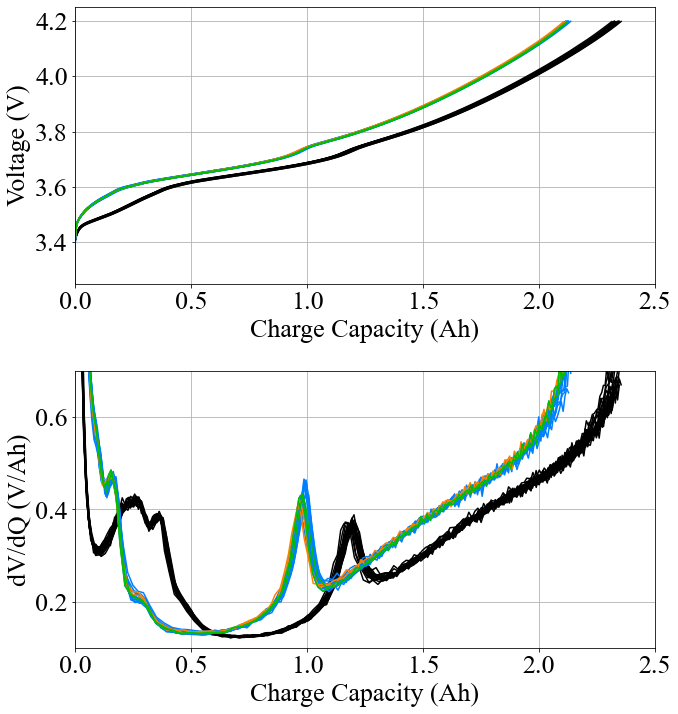

In [39]:
fig = plt.figure(figsize=(10,10.5))

# Voltage vs Capacity
ax1 = fig.add_subplot(211)
ax1.set_xlabel('Charge Capacity (Ah)')
ax1.set_ylabel('Voltage (V)')
ax1.set_xlim(CAPACITY_LIMITS)
ax1.set_ylim(VOLTAGE_LIMITS)

# dV/dQ
ax2 = fig.add_subplot(212)
ax2.set_xlabel('Charge Capacity (Ah)')
ax2.set_ylabel('dV/dQ (V/Ah)')
ax2.set_xlim(CAPACITY_LIMITS)
ax2.set_ylim((0, 0.6))
    
idx_of_interest_1 = []
idx_of_interest_2 = []

for idx, features_by_cycle_list in enumerate(features_list):
    
    is_micro_formation = len(re.findall(r'_MicroForm_', file_path_list[idx])) > 0

    color = BLUE if is_micro_formation else BLACK
    cellid = cell_id_list[idx]

    # Manually inspect the data and pick out cells to highlight
    # These cellids are picked based on which cells have had a current bump
    if cellid in CELLID_INTERESTING_1:
        idx_of_interest_1.append(idx)
        continue
    elif cellid in CELLID_INTERESTING_2:
        idx_of_interest_2.append(idx)
    elif cellid == 9:
        continue
    
    features = features_by_cycle_list[-1]
    
    idx_end = int(np.where(features['Q'] == np.min(features['Q'].iloc[np.where(features['V'] > 4.199)[0]]))[0])
    ax1.plot(features['Q'].iloc[0:idx_end], features['V'].iloc[0:idx_end], label='_nolegend_', color=color)
    ax2.plot(features['Q'].iloc[0:idx_end], 1/features['dQdV'].iloc[0:idx_end], label='_nolegend_', color=color)

for idx in idx_of_interest_1:

    cellid = cell_id_list[idx]
    features = features_list[idx][-1]
    
    idx_end = int(np.where(features['Q'] == np.min(features['Q'].iloc[np.where(features['V'] > 4.199)[0]]))[0])
    ax1.plot(features['Q'].iloc[0:idx_end], features['V'].iloc[0:idx_end], label=f'Cell {cellid}', color=ORANGE)
    ax2.plot(features['Q'].iloc[0:idx_end], 1/features['dQdV'].iloc[0:idx_end], label=f'Cell {cellid}', color=ORANGE)
    

for idx in idx_of_interest_2:

    cellid = cell_id_list[idx]
    features = features_list[idx][-1]
    
    idx_end = int(np.where(features['Q'] == np.min(features['Q'].iloc[np.where(features['V'] > 4.199)[0]]))[0])
    ax1.plot(features['Q'].iloc[0:idx_end], features['V'].iloc[0:idx_end], label=f'Cell {cellid}', color=GREEN)
    ax2.plot(features['Q'].iloc[0:idx_end], 1/features['dQdV'].iloc[0:idx_end], label=f'Cell {cellid}', color=GREEN)
    

ax1.set_xlim((0, 2.5))
ax1.set_ylim((3.25, 4.25))
# ax1.legend()
# ax2.legend()
ax2.set_xlim((0, 2.5))
ax2.set_ylim((0.1, 0.7))
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}all_cells_last_cycle_voltage_curves_charge.png", dpi=DPI)

### Discharge curves

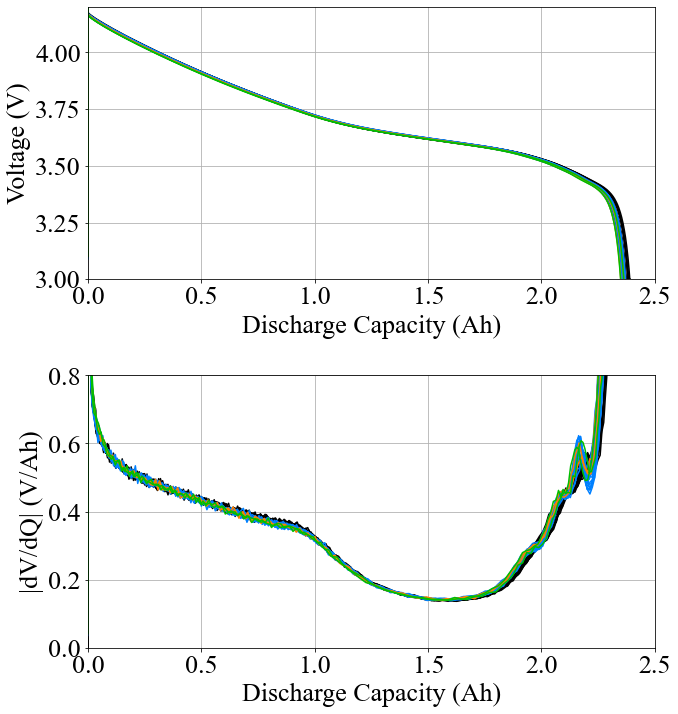

In [38]:
fig = plt.figure(figsize=(10,10.5))

# Voltage vs Capacity
ax1 = fig.add_subplot(211)
ax1.set_xlabel('Discharge Capacity (Ah)')
ax1.set_ylabel('Voltage (V)')
ax1.set_xlim(CAPACITY_LIMITS)
ax1.set_ylim(VOLTAGE_LIMITS)

# dV/dQ
ax2 = fig.add_subplot(212)
ax2.set_xlabel('Discharge Capacity (Ah)')
ax2.set_ylabel('|dV/dQ| (V/Ah)')
ax2.set_xlim(CAPACITY_LIMITS)
ax2.set_ylim((0, 0.8))

idx_of_interest_1 = []
idx_of_interest_2 = []

for idx, features_by_cycle_list in enumerate(features_list):
    
    is_micro_formation = len(re.findall(r'_MicroForm_', file_path_list[idx])) > 0

    color = BLUE if is_micro_formation else BLACK
    cellid = cell_id_list[idx]
    
    # Manually inspect the data and pick out cells to highlight
    # These cellids are picked based on which cells have had a current bump
    if cellid in CELLID_INTERESTING_1:
        idx_of_interest_1.append(idx)
        continue
    elif cellid in CELLID_INTERESTING_2:
        idx_of_interest_2.append(idx)
        continue
    elif cellid == 9:
        continue

    features = features_by_cycle_list[-1]
    ax1.plot(features['Qd'], features['V'], label=label, color=color)
    ax2.plot(features['Qd'], np.abs(1/features['dQdV']), label='_nolegend_', color=color)

for idx in idx_of_interest_1:
    features_by_cycle_list = features_list[idx]
    cellid = cell_id_list[idx]
    features = features_by_cycle_list[-1]
    ax1.plot(features['Qd'], features['V'], label=f'Cell {cellid}', color=ORANGE)
    ax2.plot(features['Qd'], np.abs(1/features['dQdV']), label=f'Cell {cellid}', color=ORANGE)
    
for idx in idx_of_interest_2:
    features_by_cycle_list = features_list[idx]
    cellid = cell_id_list[idx]
    features = features_by_cycle_list[-1]
    ax1.plot(features['Qd'], features['V'], label=f'Cell {cellid}', color=GREEN)
    ax2.plot(features['Qd'], np.abs(1/features['dQdV']), label=f'Cell {cellid}', color=GREEN)
    

    
# ax1.legend()
# ax2.legend()
ax1.set_xlim((0, 2.5))
ax1.set_ylim((3.0, 4.2))
ax2.set_xlim((0, 2.5))
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}all_cells_last_cycle_voltage_curves_discharge.png", dpi=DPI)

### Discharge curves, zoomed

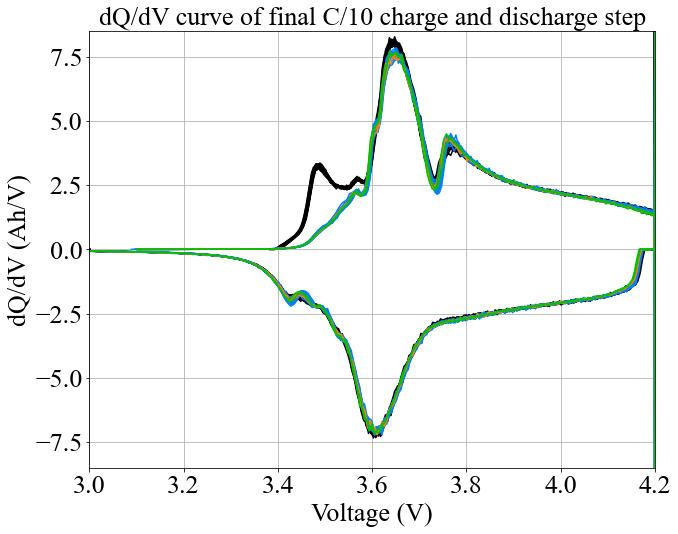

In [37]:
fig = plt.figure(figsize=(10,8))

# dQ/dV
ax3 = fig.add_subplot(111)
ax3.set_xlabel('Voltage (V)')
ax3.set_ylabel('dQ/dV (Ah/V)')
ax3.set_ylim((-8.5, 8.5))
ax3.set_xlim((3.0, 4.2))
    
idx_of_interest_1 = []
idx_of_interest_2 = []

for idx, features_by_cycle_list in enumerate(features_list):
    
    is_micro_formation = len(re.findall(r'_MicroForm_', file_path_list[idx])) > 0

    color = BLUE if is_micro_formation else BLACK
    cellid = cell_id_list[idx]

    # Manually inspect the data and pick out cells to highlight
    # These cellids are picked based on which cells have had a current bump
    if cellid in CELLID_INTERESTING_1:
        idx_of_interest_1.append(idx)
        continue
    elif cellid in CELLID_INTERESTING_2:
        idx_of_interest_2.append(idx)
        continue
    elif cellid == 9:
        continue

    features = features_by_cycle_list[-1]
    ax3.plot(features['V'], (features['dQdV']), label='_nolegend_', color=color)

for idx in idx_of_interest_1:
    features = features_list[idx][-1]
    cellid = cell_id_list[idx]
    ax3.plot(features['V'], features['dQdV'], label=f'Cell {cellid}', color=ORANGE)
    

for idx in idx_of_interest_2:
    features = features_list[idx][-1]
    cellid = cell_id_list[idx]
    ax3.plot(features['V'], features['dQdV'], label=f'Cell {cellid}', color=GREEN)
    
    
    
plt.title('dQ/dV curve of final C/10 charge and discharge step')
plt.tight_layout()
plt.savefig(f"{OUTPUT_PATH}{PROJECT_FOLDER}all_cells_last_cycle_dqdv.png", dpi=DPI)